### Aim:

Our aim in this project is to create a biometric identification system using face recognition for faces wearing masks. This project was inspired by the COVID-19 pandemic, which was a serious health risk that prompted people to start wearing masks.


### Contributors:

1. Aryan Bhapkar
2. Manasi Pawaskar
3. Dev Chandan

### Import Dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import shutil
import zipfile
import tensorflow as tf

In [ ]:
path_arcface = '/content/drive/MyDrive/Colab Notebooks/arcface.h5'

In [ ]:
original_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Biometrics/ourdataset 1.1.zip'

In [ ]:
dataset_path = '/content/dataset'

In [ ]:
zip_file_path = original_dataset_path
destination_dir = dataset_path

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract the contents of the zip file to a temporary directory
    zip_ref.extractall("temp_directory")

# Move each subdirectory to the destination directory
for subdirectory in os.listdir("temp_directory"):
    shutil.move(os.path.join("temp_directory", subdirectory), destination_dir)

# Remove the temporary directory
shutil.rmtree("temp_directory")


In [ ]:
img = cv2.imread('/content/dataset/001/Unmasked/00000004.jpg')


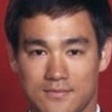

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

In [ ]:
!rm -r '/content/dataset/Masked'

In [ ]:
!rm -r '/content/dataset/Unmasked'

In [ ]:
!mv '/content/dataset/104' '/content/dataset/48'

In [ ]:
# Copy a directory from Colab files section to your Google Drive
# !cp -r "/content/dataset" "/content/drive/My Drive/Colab Notebooks/Biometrics/"

### Pre-processing and Image detection

In [ ]:
folders = os.listdir(dataset_path)

In [ ]:
len(folders)

103

In [ ]:
num_folders = 90

In [ ]:
selected_folders = np.random.choice(folders, num_folders, replace = False)

In [ ]:
len(selected_folders)

90

In [ ]:
new_dataset_path = '/content/dataset_detected'

In [ ]:
if not os.path.exists(new_dataset_path):
    os.makedirs(new_dataset_path)

In [ ]:
import os
import glob

def count_subfolders_with_more_than_15_images(directory_path):
    subfolders = []
    for root, dirs, files in os.walk(directory_path):
        for dir in dirs:
            subfolders.append(os.path.join(root, dir))

    num_images = {}
    for folder in subfolders:
        num_images[folder] = len(glob.glob(folder + "/*.jpg")) + len(glob.glob(folder + "/*.jpeg")) + len(glob.glob(folder + "/*.png"))

    count = 0
    for folder, num in num_images.items():
        if num > 15:
            count += 1
    return count


In [ ]:
directory_path = dataset_path
count = count_subfolders_with_more_than_15_images(directory_path)
print("Number of subfolders with more than 15 images:", count)

Number of subfolders with more than 15 images: 197


In [ ]:
import os

def count_folders_and_images(directory_path):
    folder_count = 0
    image_count = 0

    # Iterate over all directories and files in the directory
    for root, dirs, files in os.walk(directory_path):
        folder_count += len(dirs) # Increment folder count for each subdirectory
        for file in files:
            # Increment image count for each file with extension .jpg, .png or .jpeg
            if file.endswith(('.jpg', '.png', '.jpeg')):
                image_count += 1

    print("Number of folders:", folder_count)
    print("Number of images:", image_count)


In [ ]:
def faceDetection(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.01, minNeighbors=1, minSize=(110, 110))

    # Find the largest face detected
    largest_area = 0
    largest_rect = None
    for (x, y, w, h) in faces:
        rect_area = w * h
        if rect_area > largest_area:
            largest_area = rect_area
            largest_rect = (x, y, w, h)

    # If a face is detected, save it to the output folder
    if largest_rect is not None:
        x, y, w, h = largest_rect
        face = img[y:y+h, x:x+w]
        return face

    else:
      return None

In [ ]:
# Set the original and new directories
original_dir = '/content/dataset'
new_dir = '/content/combined'

# Loop through each folder in the original directory
for folder in os.listdir(original_dir):
    # Skip any files in the original directory
    if not os.path.isdir(os.path.join(original_dir, folder)):
        continue

    # Create a new folder in the new directory
    new_folder = os.path.join(new_dir, folder)
    os.makedirs(new_folder, exist_ok=True)

    # Loop through the masked and unmasked folders in the current folder
    for subfolder in ('Masked', 'Unmasked'):
        subfolder_path = os.path.join(original_dir, folder, subfolder)

        # Skip the subfolder if it doesn't exist
        if not os.path.exists(subfolder_path):
            continue

        # Loop through each file in the subfolder and move it to the new folder
        for file in os.listdir(subfolder_path):
            src = os.path.join(subfolder_path, file)
            dst = os.path.join(new_folder, file)
            shutil.move(src, dst)

        # Remove the now-empty subfolder
        os.rmdir(subfolder_path)


In [ ]:
import os
import cv2

def extract_faces(selected_folders, dataset_path, new_dataset_path, num_folders):
    total_folders = 0

    for folder in selected_folders:
        folder_path = os.path.join(dataset_path, folder)
        images = os.listdir(folder_path)

        # Only process the folder if it has at least 30 images and
        # we haven't already processed 5 folders
        if len(images) >= 20 and total_folders < num_folders:
            total_folders += 1
            j = 0  # counter for the number of images saved to the output folder

            # Loop through each image in the folder
            for image_name in images:
                image_path = os.path.join(folder_path, image_name)
                img = cv2.imread(image_path)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
                faces = face_cascade.detectMultiScale(gray, scaleFactor=1.01, minNeighbors=1, minSize=(110, 110))

                # Find the largest face detected
                largest_area = 0
                largest_rect = None
                for (x, y, w, h) in faces:
                    rect_area = w * h
                    if rect_area > largest_area:
                        largest_area = rect_area
                        largest_rect = (x, y, w, h)

                # If a face is detected, save it to the output folder
                if largest_rect is not None and j < 30:
                    x, y, w, h = largest_rect
                    face = img[y:y+h, x:x+w]
                    output_dir = os.path.join(new_dataset_path, folder)

                    # Create the output directory if it doesn't exist
                    if not os.path.exists(output_dir) and total_folders <= num_folders:
                        os.makedirs(output_dir)

                    # Save the face image to the output directory
                    new_image_path = os.path.join(output_dir, image_name)
                    # face_image = cv2.resize(face, (112, 112))
                    cv2.imwrite(new_image_path, face)

                    # Increment the counter
                    j += 1

                    # Break the loop if we've saved 15 images to the output folder
                    if j == 20:
                        break


new_dir = '/content/combined'
folders = os.listdir(new_dir)
num_folders = 90
selected_folders = np.random.choice(folders, num_folders, replace = False)
new_dataset_path = '/content/dataset_detected'
extract_faces(
    selected_folders = selected_folders,
    dataset_path = new_dir,
    new_dataset_path = new_dataset_path,
    num_folders = num_folders
    )


### Train and Test Split (mix data)

In [ ]:
# Set the path to the directory containing the face images
face_dir = '/content/dataset_detected'

In [ ]:
img_height, img_width = 112, 112

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  face_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=64)

Found 1728 files belonging to 88 classes.
Using 1383 files for training.


In [ ]:
train_ds_int = tf.keras.utils.image_dataset_from_directory(
  face_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  label_mode='int',
  batch_size=64)

Found 1728 files belonging to 88 classes.
Using 1383 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  face_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=64)

Found 1728 files belonging to 88 classes.
Using 345 files for validation.


In [ ]:
val_ds_int = tf.keras.utils.image_dataset_from_directory(
  face_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  label_mode='int',
  batch_size=64)

Found 1728 files belonging to 88 classes.
Using 345 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)
print(len(class_names))

['002', '003', '004', '006', '007', '008', '009', '010', '011', '012', '014', '015', '016', '017', '018', '019', '020', '021', '022', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '038', '039', '040', '041', '042', '043', '044', '046', '047', '048', '049', '051', '052', '054', '055', '056', '057', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '073', '074', '075', '076', '077', '078', '079', '080', '081', '084', '085', '086', '087', '088', '089', '092', '093', '094', '095', '096', '097', '098', '099', '101', '102', '48']
88


### Image Plotting

(112, 112, 3)
(112, 112, 3)
(112, 112, 3)
(112, 112, 3)
(112, 112, 3)
(112, 112, 3)
(112, 112, 3)
(112, 112, 3)
(112, 112, 3)


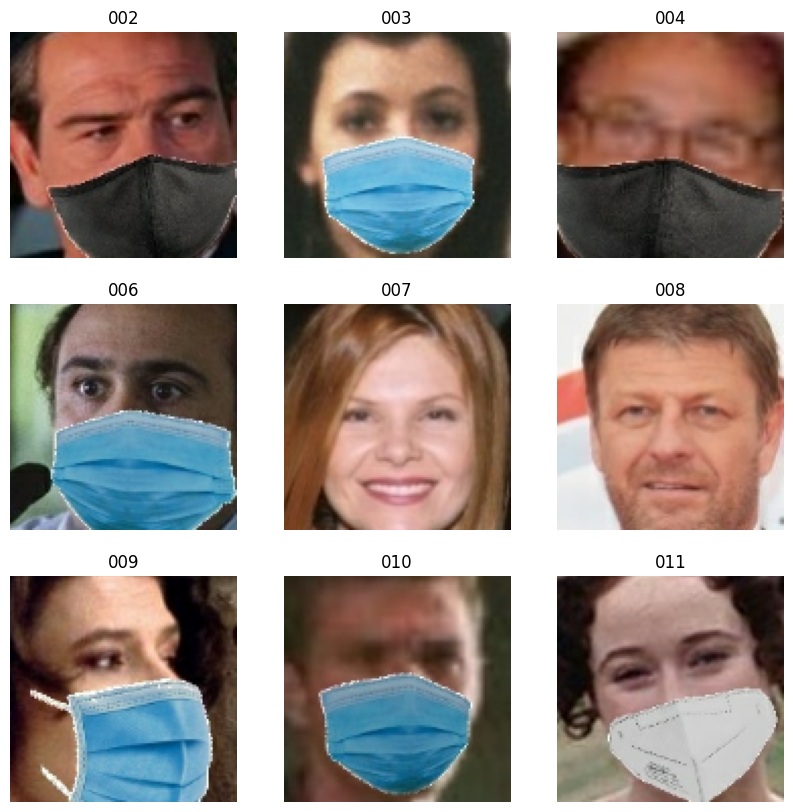

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    print(images[i].shape)
    plt.axis("off")

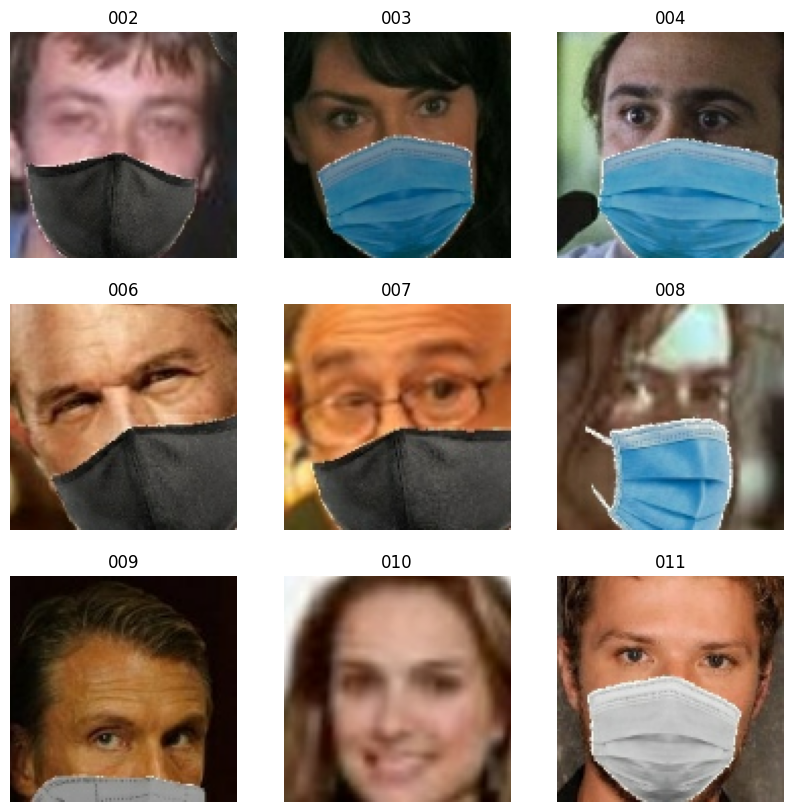

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

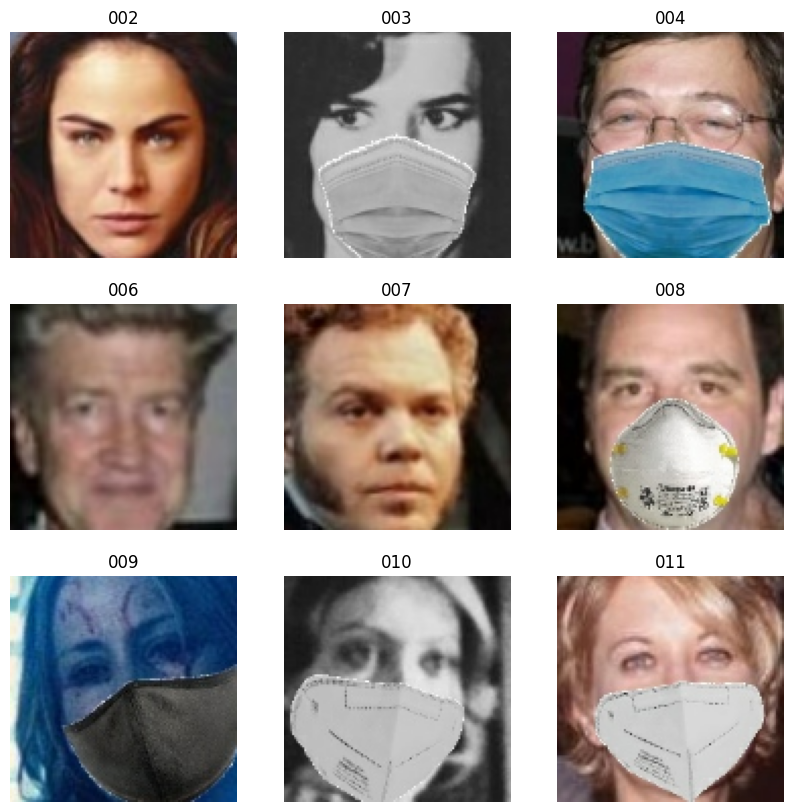

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(3):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

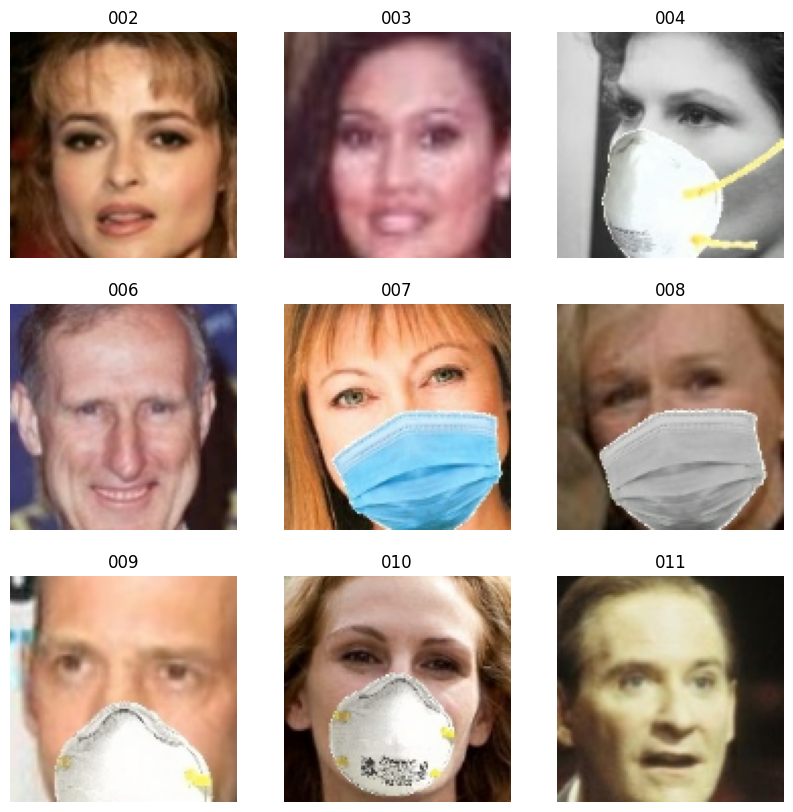

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(4):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

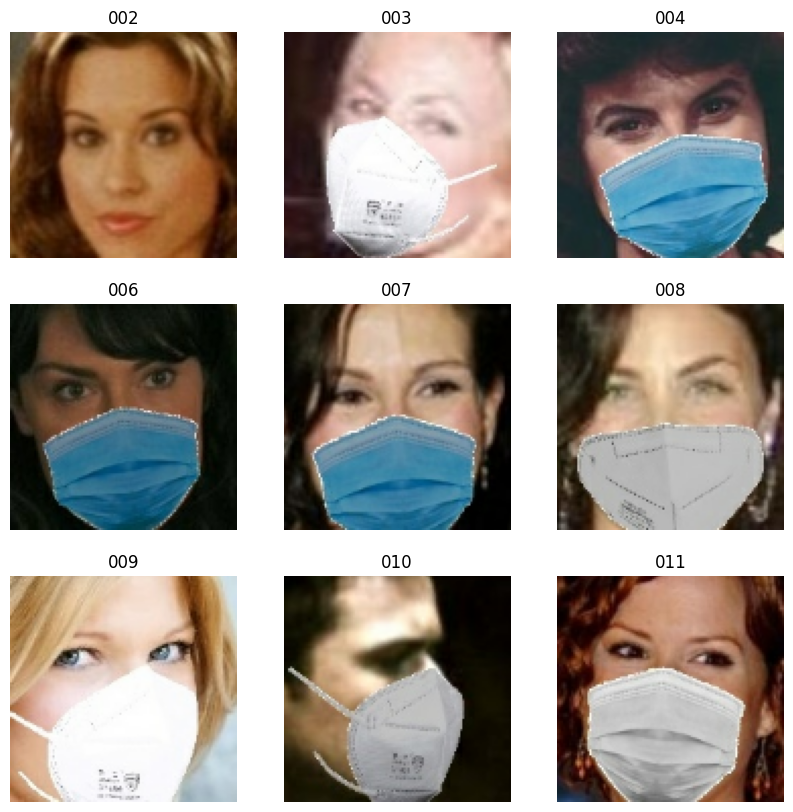

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(5):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  print(type(image_batch))
  print(type(labels_batch))
  break


(64, 112, 112, 3)
(64, 88)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


### Arc Face

In [ ]:
# arcface = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Biometrics/arcface_model.keras')

In [ ]:
arcface = tf.keras.models.load_model(path_arcface)

In [ ]:
arcface.summary()

Model: "arcface_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 112, 112, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 OutputLayer (Functional)    (None, 512)               16787968  
                                                                 
Total params: 40,375,680
Trainable params: 40,317,440
Non-trainable params: 58,240
_________________________________________________________________


In [ ]:
from tensorflow.keras import layers

In [ ]:
# Add a softmax layer after the final layer
arcface_output = layers.Dense(88)(arcface.output)
softmax_output = layers.Softmax()(arcface_output)

# Create a new model with the same inputs as arcface and the new softmax output
Arcface = tf.keras.Model(inputs=arcface.input, outputs=softmax_output)

In [ ]:
Arcface.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 112, 112, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 OutputLayer (Functional)    (None, 512)               16787968  
                                                                 
 dense (Dense)               (None, 88)                45144     
                                                                 
 softmax (Softmax)           (None, 88)                0         
                                                                 
Total params: 40,420,824
Trainable params: 40,362,584
Non-trainable params: 58,240
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.losses import CategoricalCrossentropy

In [ ]:
from tensorflow.keras import regularizers

# Add L2 regularization to the last dense layer
regularization = regularizers.l2(0.01)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

In [ ]:
# Compile the model with a regularization loss term
optimizer = Adam(learning_rate=0.001)
loss_fn = SparseCategoricalCrossentropy()
regularization_loss = sum(Arcface.losses)
total_loss_fn = lambda y_true, y_pred: loss_fn(y_true, y_pred) + regularization_loss
Arcface.compile(optimizer=optimizer, loss=total_loss_fn, metrics=['accuracy'], jit_compile=True)

In [ ]:
# Fit the model
epochs = 10
history = Arcface.fit(train_ds_int, epochs=epochs, validation_data=val_ds_int, callbacks=[lr_scheduler])

Epoch 1/10
22/22 [==============================] - 114s 2s/step - loss: 6.9894 - accuracy: 0.2495 - val_loss: 7.7350 - val_accuracy: 0.0580 - lr: 0.0010
Epoch 2/10
22/22 [==============================] - 4s 181ms/step - loss: 3.8716 - accuracy: 0.8525 - val_loss: 6.3539 - val_accuracy: 0.3043 - lr: 0.0010
Epoch 3/10
22/22 [==============================] - 4s 190ms/step - loss: 3.3175 - accuracy: 0.9826 - val_loss: 5.7173 - val_accuracy: 0.4232 - lr: 0.0010
Epoch 4/10
22/22 [==============================] - 4s 182ms/step - loss: 3.1550 - accuracy: 0.9848 - val_loss: 5.0702 - val_accuracy: 0.5391 - lr: 0.0010
Epoch 5/10
22/22 [==============================] - 4s 182ms/step - loss: 2.9712 - accuracy: 0.9870 - val_loss: 4.6906 - val_accuracy: 0.5826 - lr: 0.0010
Epoch 6/10
22/22 [==============================] - 5s 205ms/step - loss: 2.8092 - accuracy: 0.9892 - val_loss: 4.4223 - val_accuracy: 0.6029 - lr: 0.0010
Epoch 7/10
22/22 [==============================] - 4s 183ms/step - los

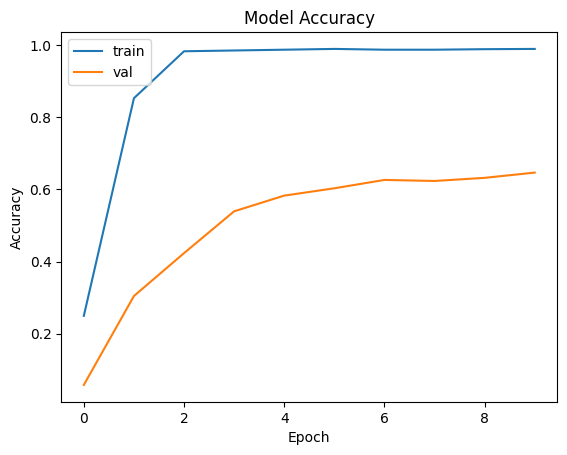

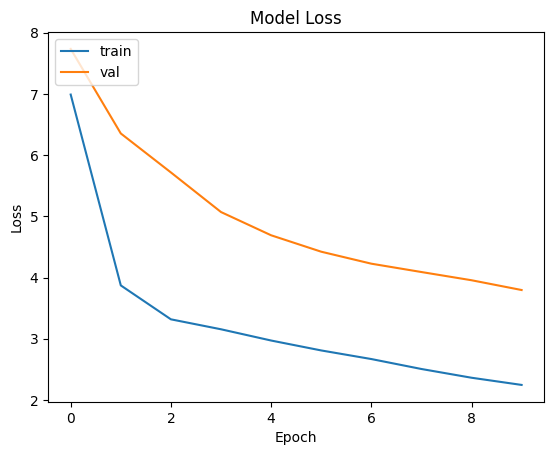

In [ ]:

# plot accuracy curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# plot loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


### Creating Imposter dataset.
Images the model has never seen

In [ ]:
dataset_path = '/content/combined'

In [ ]:
num_folders = 14

In [ ]:
folders = os.listdir(dataset_path)

In [ ]:
selected_set = set(selected_folders)

In [ ]:
len(selected_set)

90

In [ ]:
# Choose 25 random folders that are not in the selected set
available_folders = set(folders) - selected_set
selected_folders_imposter = np.random.choice(list(available_folders), num_folders, replace=False)

In [ ]:
len(available_folders)

13

In [ ]:
len(selected_set)

90

In [ ]:
selected_set

In [ ]:
len(selected_folders_imposter)

13

In [ ]:
selected_folders_imposter

array(['090', '050', '072', '091', '053', '058', '103', '023', '045',
       '005', '037', '001', '013'], dtype='<U3')

In [ ]:
new_dataset_path = '/content/imposter'

In [ ]:
if not os.path.exists(new_dataset_path):
    os.makedirs(new_dataset_path)

In [ ]:
extract_faces(selected_folders_imposter, '/content/combined', new_dataset_path, 13)

In [ ]:
count_folders_and_images('/content/imposter')

Number of folders: 13
Number of images: 250


In [ ]:
img_height, img_width = 112, 112

In [ ]:
import tensorflow as tf

In [ ]:
imposter_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/dataset',
  seed=123,
  # image_size=(img_height, img_width),
  batch_size=32)

Found 26079 files belonging to 105 classes.


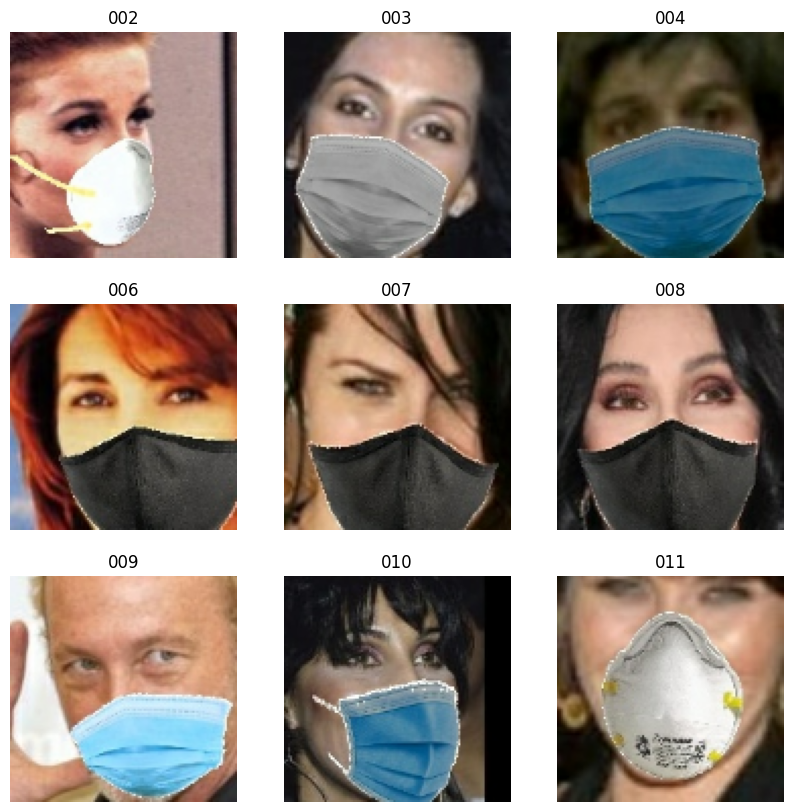

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in imposter_ds.take(5):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

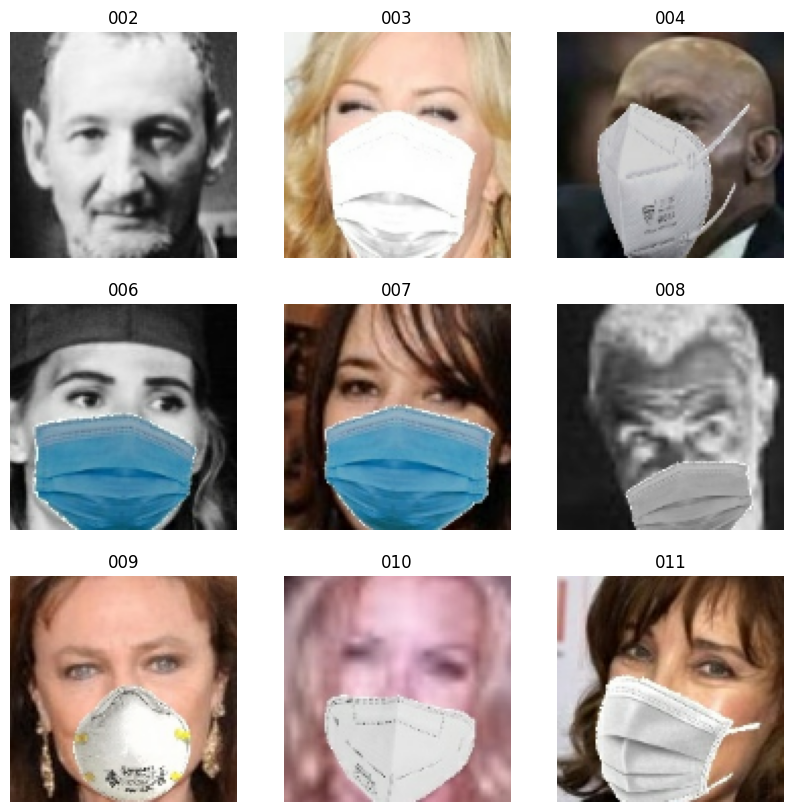

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in imposter_ds.take(6):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

In [ ]:
type(imposter_ds)

tensorflow.python.data.ops.batch_op._BatchDataset

In [ ]:
batch_size = None  # Provide the actual batch size used in your dataset

# Iterate over each batch and count the number of photos in each batch
num_photos_per_batch = []
for batch in imposter_ds:
    num_photos = tf.data.Dataset.from_tensor_slices(batch).reduce(0, lambda x, _: x + 1)
    num_photos_per_batch.append(num_photos.numpy())

print("Number of photos in each batch:", num_photos_per_batch)

Number of photos in each batch: [32, 32, 32, 32, 32, 32, 32, 26]


In [ ]:
total_imposter_images = sum(num_photos_per_batch)

In [ ]:
total_imposter_images

250

### DET Curve

In [ ]:
train_embeddings = []

In [ ]:
train_ds_int_shuffled = train_ds_int.shuffle(buffer_size=1376, reshuffle_each_iteration=False)
train_subset = train_ds_int_shuffled.take(total_imposter_images)

In [ ]:
train_subset

<_TakeDataset element_spec=(TensorSpec(shape=(None, 112, 112, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
type(train_subset)

tensorflow.python.data.ops.take_op._TakeDataset

In [ ]:
train_embeddings = Arcface.predict(train_subset)

22/22 [==============================] - 1s 46ms/step


In [ ]:
type(train_embeddings)

numpy.ndarray

In [ ]:
train_embeddings.shape

(1383, 88)

In [ ]:
# crop the train_embeddings array to match the size of imposter_embeddings
train_embeddings = train_embeddings[:total_imposter_images, :]

In [ ]:
train_embeddings.shape

(250, 88)

In [ ]:
imposter_embeddings = Arcface.predict(imposter_ds)

8/8 [==============================] - 4s 555ms/step


In [ ]:
imposter_embeddings.shape

(250, 88)

In [ ]:
# Calculate the distances between genuine_embeddings and imposter_embeddings
genuine_distances = np.linalg.norm(train_embeddings - train_embeddings.mean(axis=0), axis=1)
imposter_distances = np.linalg.norm(imposter_embeddings - train_embeddings.mean(axis=0), axis=1)

In [ ]:
genuine_distances

array([0.95379406, 0.9920382 , 0.9886211 , 0.98280483, 0.99003685,
       0.97834784, 0.9940477 , 0.98366356, 0.99407536, 0.98825926,
       0.998663  , 0.9935344 , 0.9893689 , 0.9992299 , 0.98719573,
       0.97594494, 0.9639319 , 0.98959446, 0.9948743 , 0.99029624,
       0.99482745, 0.9861127 , 0.997952  , 0.9864161 , 0.99325657,
       0.99394166, 0.99912494, 0.9661495 , 0.97808444, 0.9817749 ,
       0.98603386, 0.9866125 , 0.9860339 , 0.9935078 , 0.8304789 ,
       0.9880169 , 0.98464346, 0.9890375 , 0.99089074, 0.9981609 ,
       0.9812634 , 0.97875965, 0.9936496 , 0.99306047, 0.97997576,
       0.98980695, 0.99102104, 0.99503374, 0.99461454, 0.97811496,
       0.98862576, 0.992903  , 0.99171984, 0.9888895 , 0.98226535,
       0.96756345, 0.9944555 , 0.9940102 , 0.9750911 , 1.0006847 ,
       0.9930819 , 0.99921113, 0.9843806 , 0.9826564 , 1.0021667 ,
       0.99013025, 0.98648703, 0.98955464, 0.9829723 , 0.98159313,
       0.9948578 , 0.9871543 , 0.97671014, 0.9910104 , 0.98080

In [ ]:
imposter_distances

array([0.19619383, 0.42949578, 0.2374825 , 0.3904831 , 0.34946752,
       0.3485549 , 0.32648823, 0.44017532, 0.27175042, 0.26647076,
       0.33504134, 0.1799792 , 0.31271794, 0.3451722 , 0.57107776,
       0.39082268, 0.40878192, 0.33161578, 0.3480075 , 0.32656425,
       0.54979146, 0.2572767 , 0.35212713, 0.30153805, 0.3452973 ,
       0.42964065, 0.15096593, 0.23585184, 0.45650142, 0.28447005,
       0.66188794, 0.2617113 , 0.31385127, 0.23627695, 0.2842807 ,
       0.2473431 , 0.550223  , 0.37001342, 0.28362685, 0.70250076,
       0.42447352, 0.49957258, 0.17587852, 0.30565736, 0.8151325 ,
       0.3155269 , 0.86389923, 0.45633015, 0.38578397, 0.6596929 ,
       0.58079684, 0.36359295, 0.34817725, 0.35427332, 0.37454632,
       0.463175  , 0.4395245 , 0.30801082, 0.4659741 , 0.66042787,
       0.46085218, 0.30745307, 0.3114412 , 0.33848155, 0.26761127,
       0.42588007, 0.51155806, 0.25649   , 0.556104  , 0.28130668,
       0.6557114 , 0.29244778, 0.54992694, 0.36298487, 0.74665

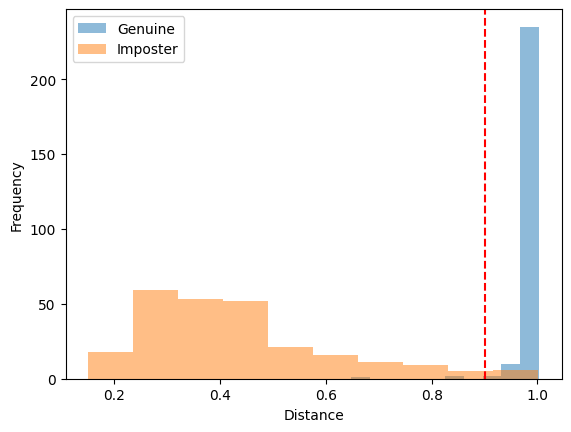

In [ ]:
# Plot the distribution of genuine and imposter distances
plt.hist(genuine_distances, alpha=0.5, label='Genuine')
plt.hist(imposter_distances, alpha=0.5, label='Imposter')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend()

# Add a threshold line
threshold = 0.9  # replace with your desired threshold value
plt.axvline(x=threshold, color='r', linestyle='--')


plt.show()

The Above DET Curve is for 250 images of Imposters and 250 images of Genuine People.
It shows that the model is able to differentiate between most imposters and genuine people.

In [ ]:
# Sort the scores in ascending order
genuine_distances = np.sort(genuine_distances)
imposter_distances = np.sort(imposter_distances)

# Initialize threshold and error rates
threshold = min(min(genuine_distances), min(imposter_distances))
eer = 1.0
far = 1.0
frr = 1.0

# Iterate through scores and calculate FAR and FRR at each threshold
for score in np.concatenate((genuine_distances, imposter_distances)):
    current_far = np.sum(imposter_distances >= score) / len(imposter_distances)
    current_frr = np.sum(genuine_distances < score) / len(genuine_distances)

    # Check if FAR and FRR are closest
    if abs(current_far - current_frr) < abs(far - frr):
        far = current_far
        frr = current_frr
        threshold = score

    # Check if FAR and FRR are equal
    if current_far == current_frr:
        eer = current_far
        threshold = score
        break

print("Equal Error Rate (EER):", eer)
print("Threshold:", threshold)


Equal Error Rate (EER): 0.02
Threshold: 0.93529063


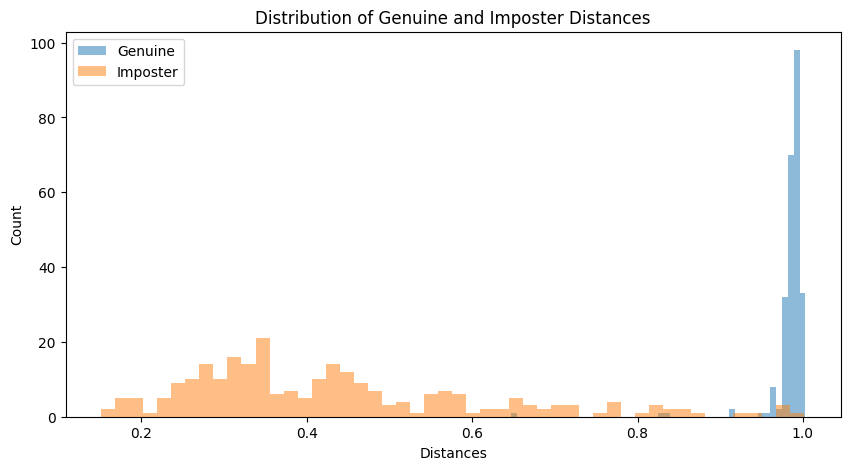

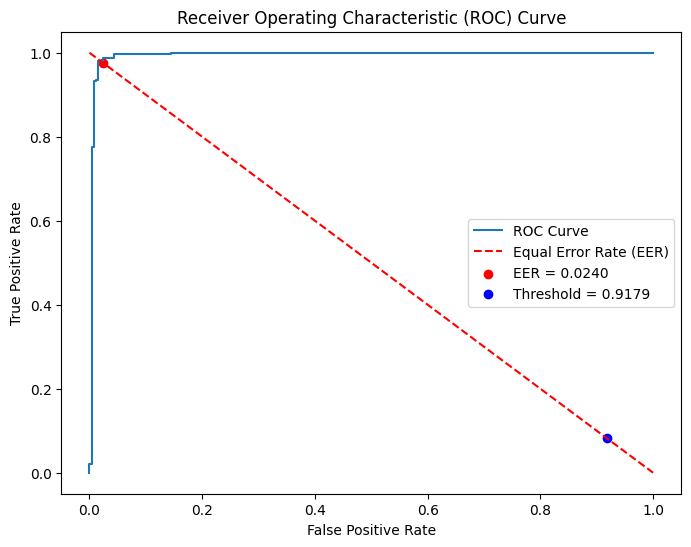

In [ ]:
from sklearn.metrics import roc_curve

# Plot the distribution of genuine and imposter distances
plt.figure(figsize=(10, 5))
plt.hist(genuine_distances, bins=50, alpha=0.5, label='Genuine')
plt.hist(imposter_distances, bins=50, alpha=0.5, label='Imposter')
plt.xlabel('Distances')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution of Genuine and Imposter Distances')
plt.show()

# Combine genuine and imposter distances
distances = np.concatenate((genuine_distances, imposter_distances))

# Create labels for genuine and imposter distances
labels = np.concatenate((np.ones(len(genuine_distances)), np.zeros(len(imposter_distances))))

# Compute Equal Error Rate (EER) and corresponding threshold
fpr, tpr, thresholds = roc_curve(labels, distances, pos_label=1)
eer_threshold = thresholds[np.nanargmin(np.absolute((1 - tpr) - fpr))]
eer = fpr[np.nanargmin(np.absolute((1 - tpr) - fpr))]

# Plot EER and Threshold
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [1, 0], 'r--', label='Equal Error Rate (EER)')
plt.scatter([eer], [1-eer], color='r', label=f'EER = {eer:.4f}')
plt.scatter([eer_threshold], [1-eer_threshold], color='b', label=f'Threshold = {eer_threshold:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()


### Conclusion

Hence, we developed a Open-set Masked Face Identifiation system, which accurately identifies strangers and misclassifies them.